## This example uses Pyramid Wavefront Sensor

In [1]:
import sys
sys.path.insert(1, '../../hcipy')

In [2]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [3]:
wavelength_wfs = 842.0E-9 # meter
telescope_diameter = 6.5 # meter
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0


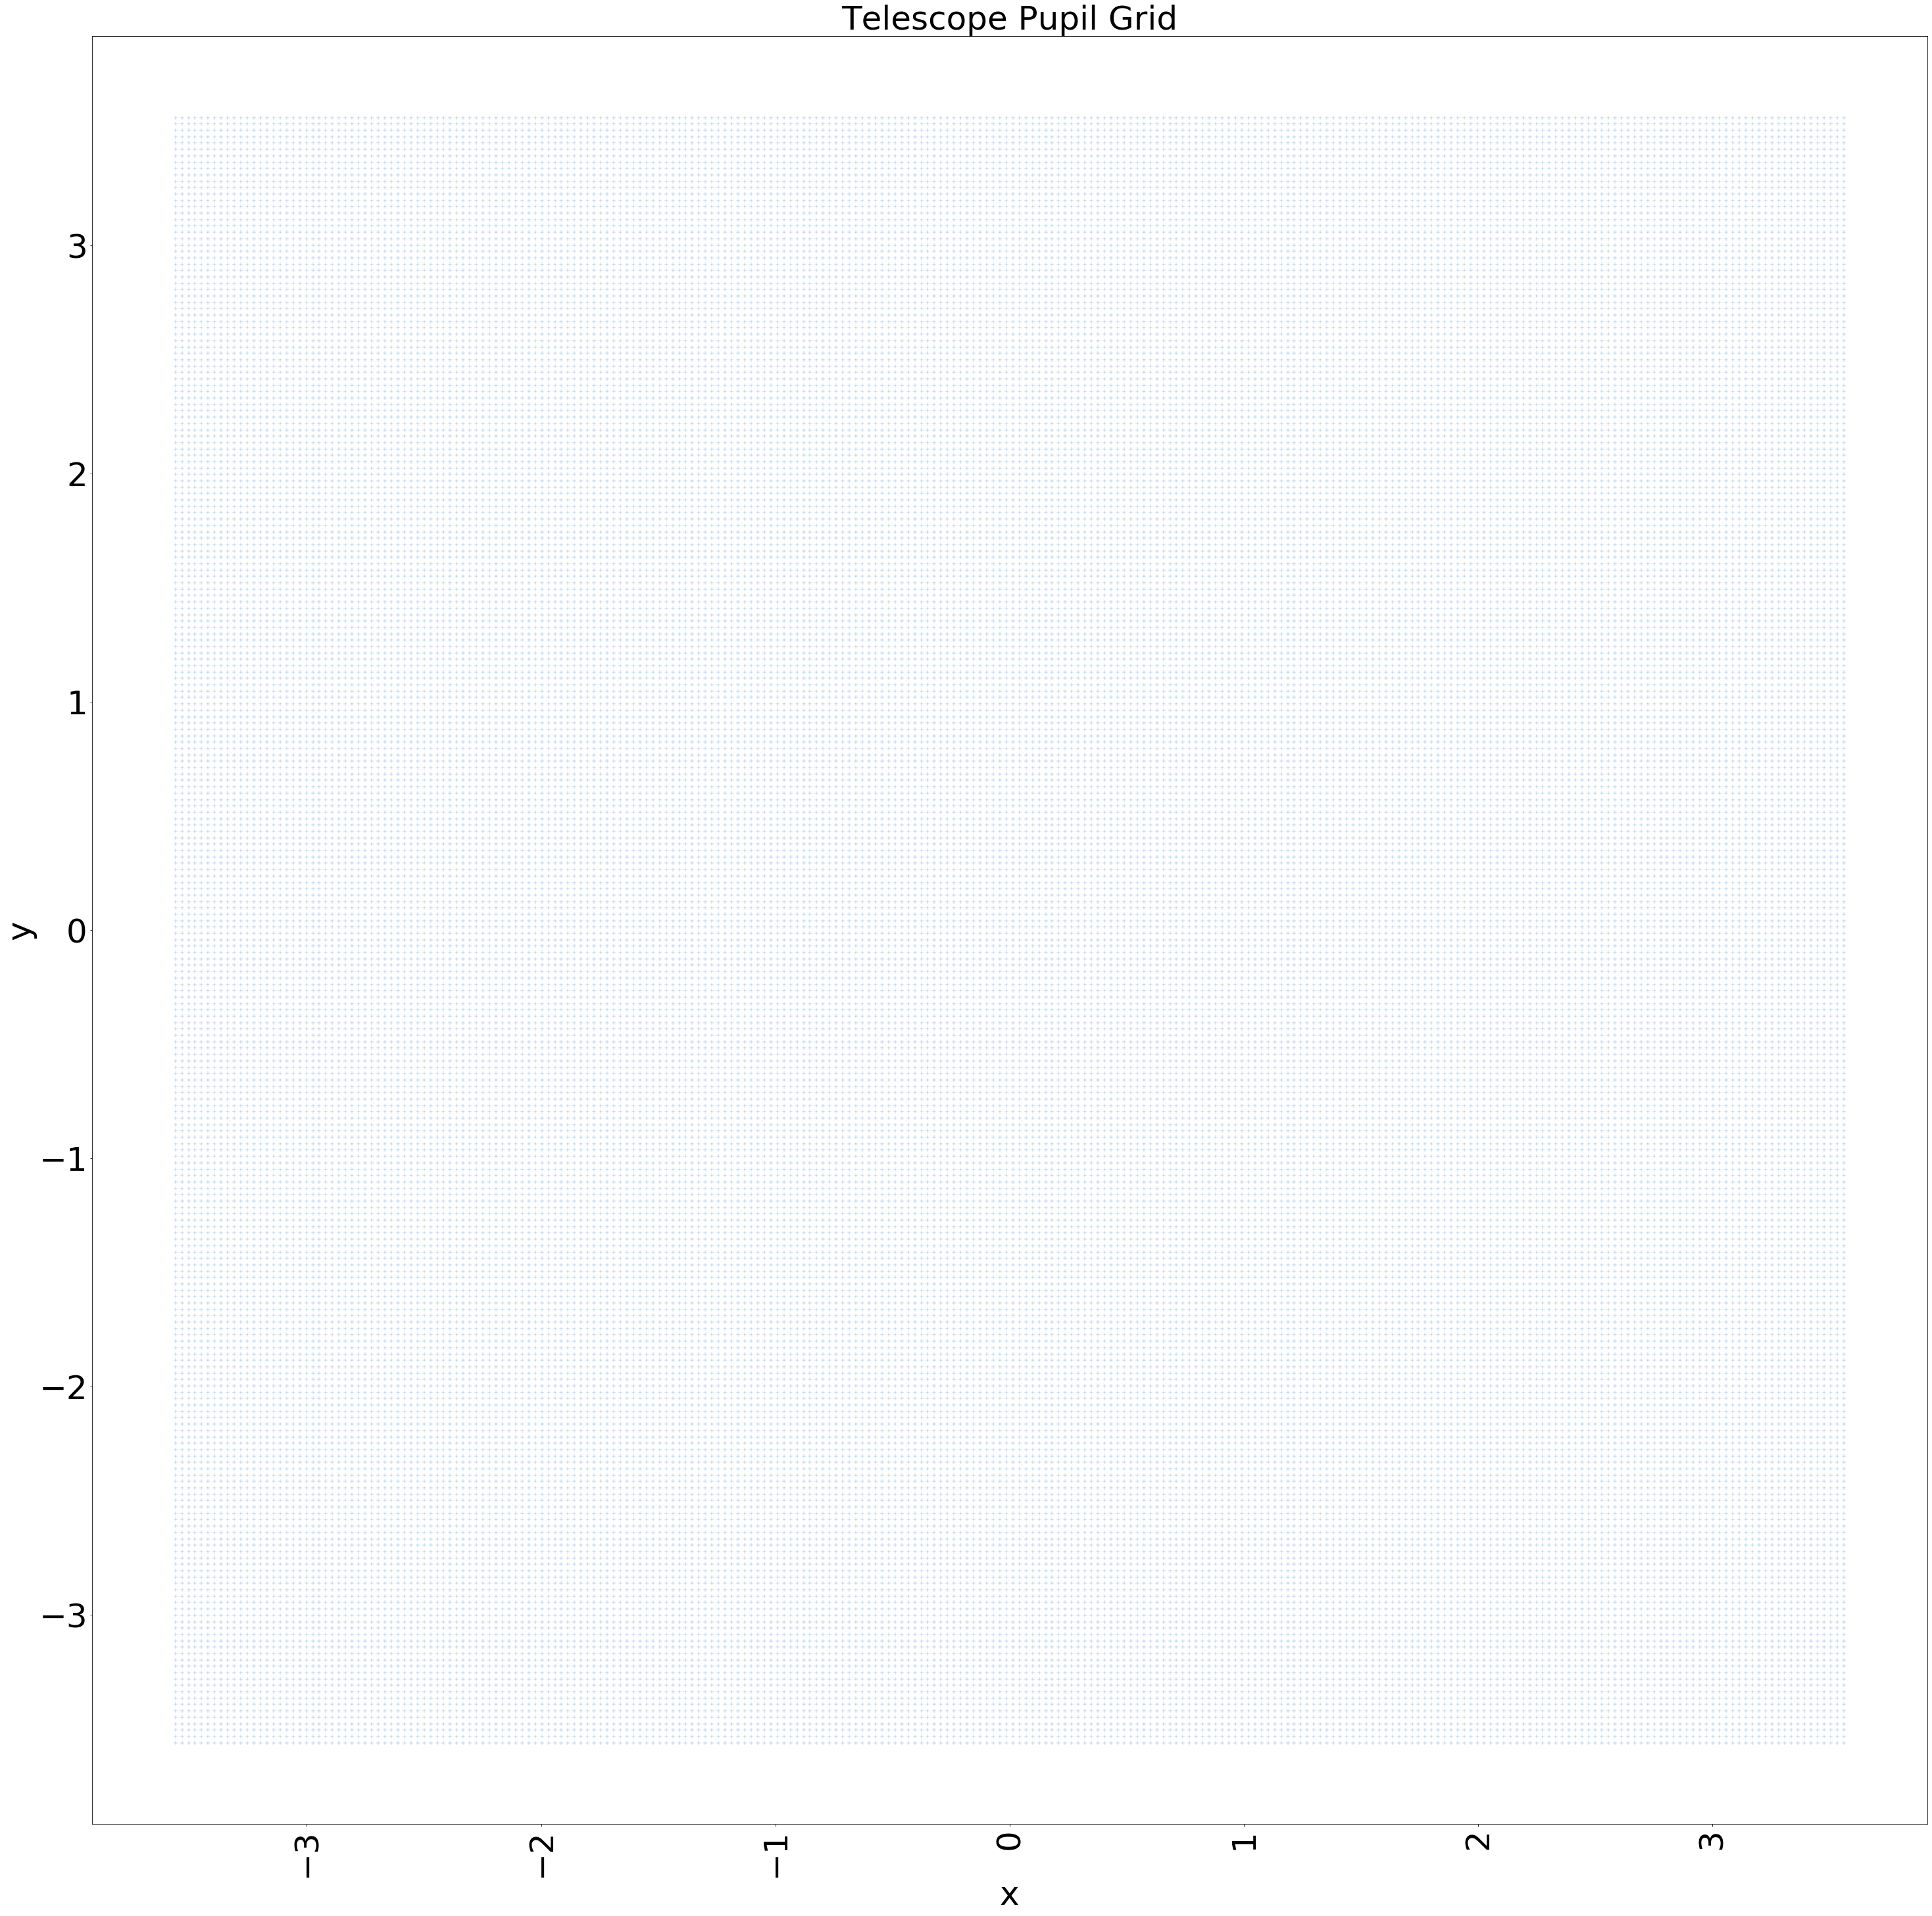

In [4]:
N = 256
telescope_pupil_grid  = make_pupil_grid(N, telescope_diameter*1.1)
## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(telescope_pupil_grid.x, telescope_pupil_grid.y, '+')
plt.title('Telescope Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

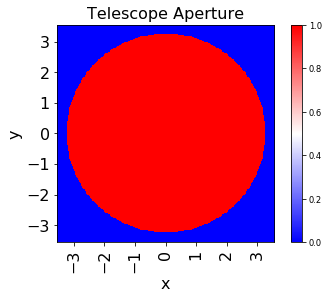

In [5]:
telescope_aperture = circular_aperture(telescope_diameter)
#telescope_aperture_grid = evaluate_supersampled(telescope_aperture, telescope_pupil_grid, 6)

telescope_aperture_grid = telescope_aperture(telescope_pupil_grid)
imshow_field(telescope_aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Telescope Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

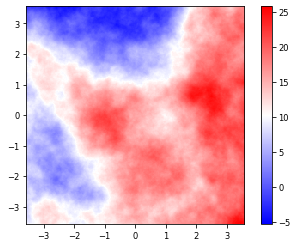

In [6]:
# Atmospheric parametersy
pixels_per_frame = 1 # In this way, you can finely control how the phase screen moves across the aperture
velocity = np.array([pixels_per_frame, 0]) # 2D Array with x and y component of the velocity
L0 = 40 # Outer scale
r0 = 0.2 # Fried parameter
height = 0 # Create only one layer near the ground

# Now make the atmosphere
np.random.seed(42)
layers = []
layer = InfiniteAtmosphericLayer(telescope_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), 
                                L0, velocity*telescope_pupil_grid.delta[0], height, 2)
layers.append(layer)
atmosphere = MultiLayerAtmosphere(layers, False)
imshow_field(layer.phase_for(wavelength_wfs), cmap='bwr')
plt.colorbar()
plt.show()

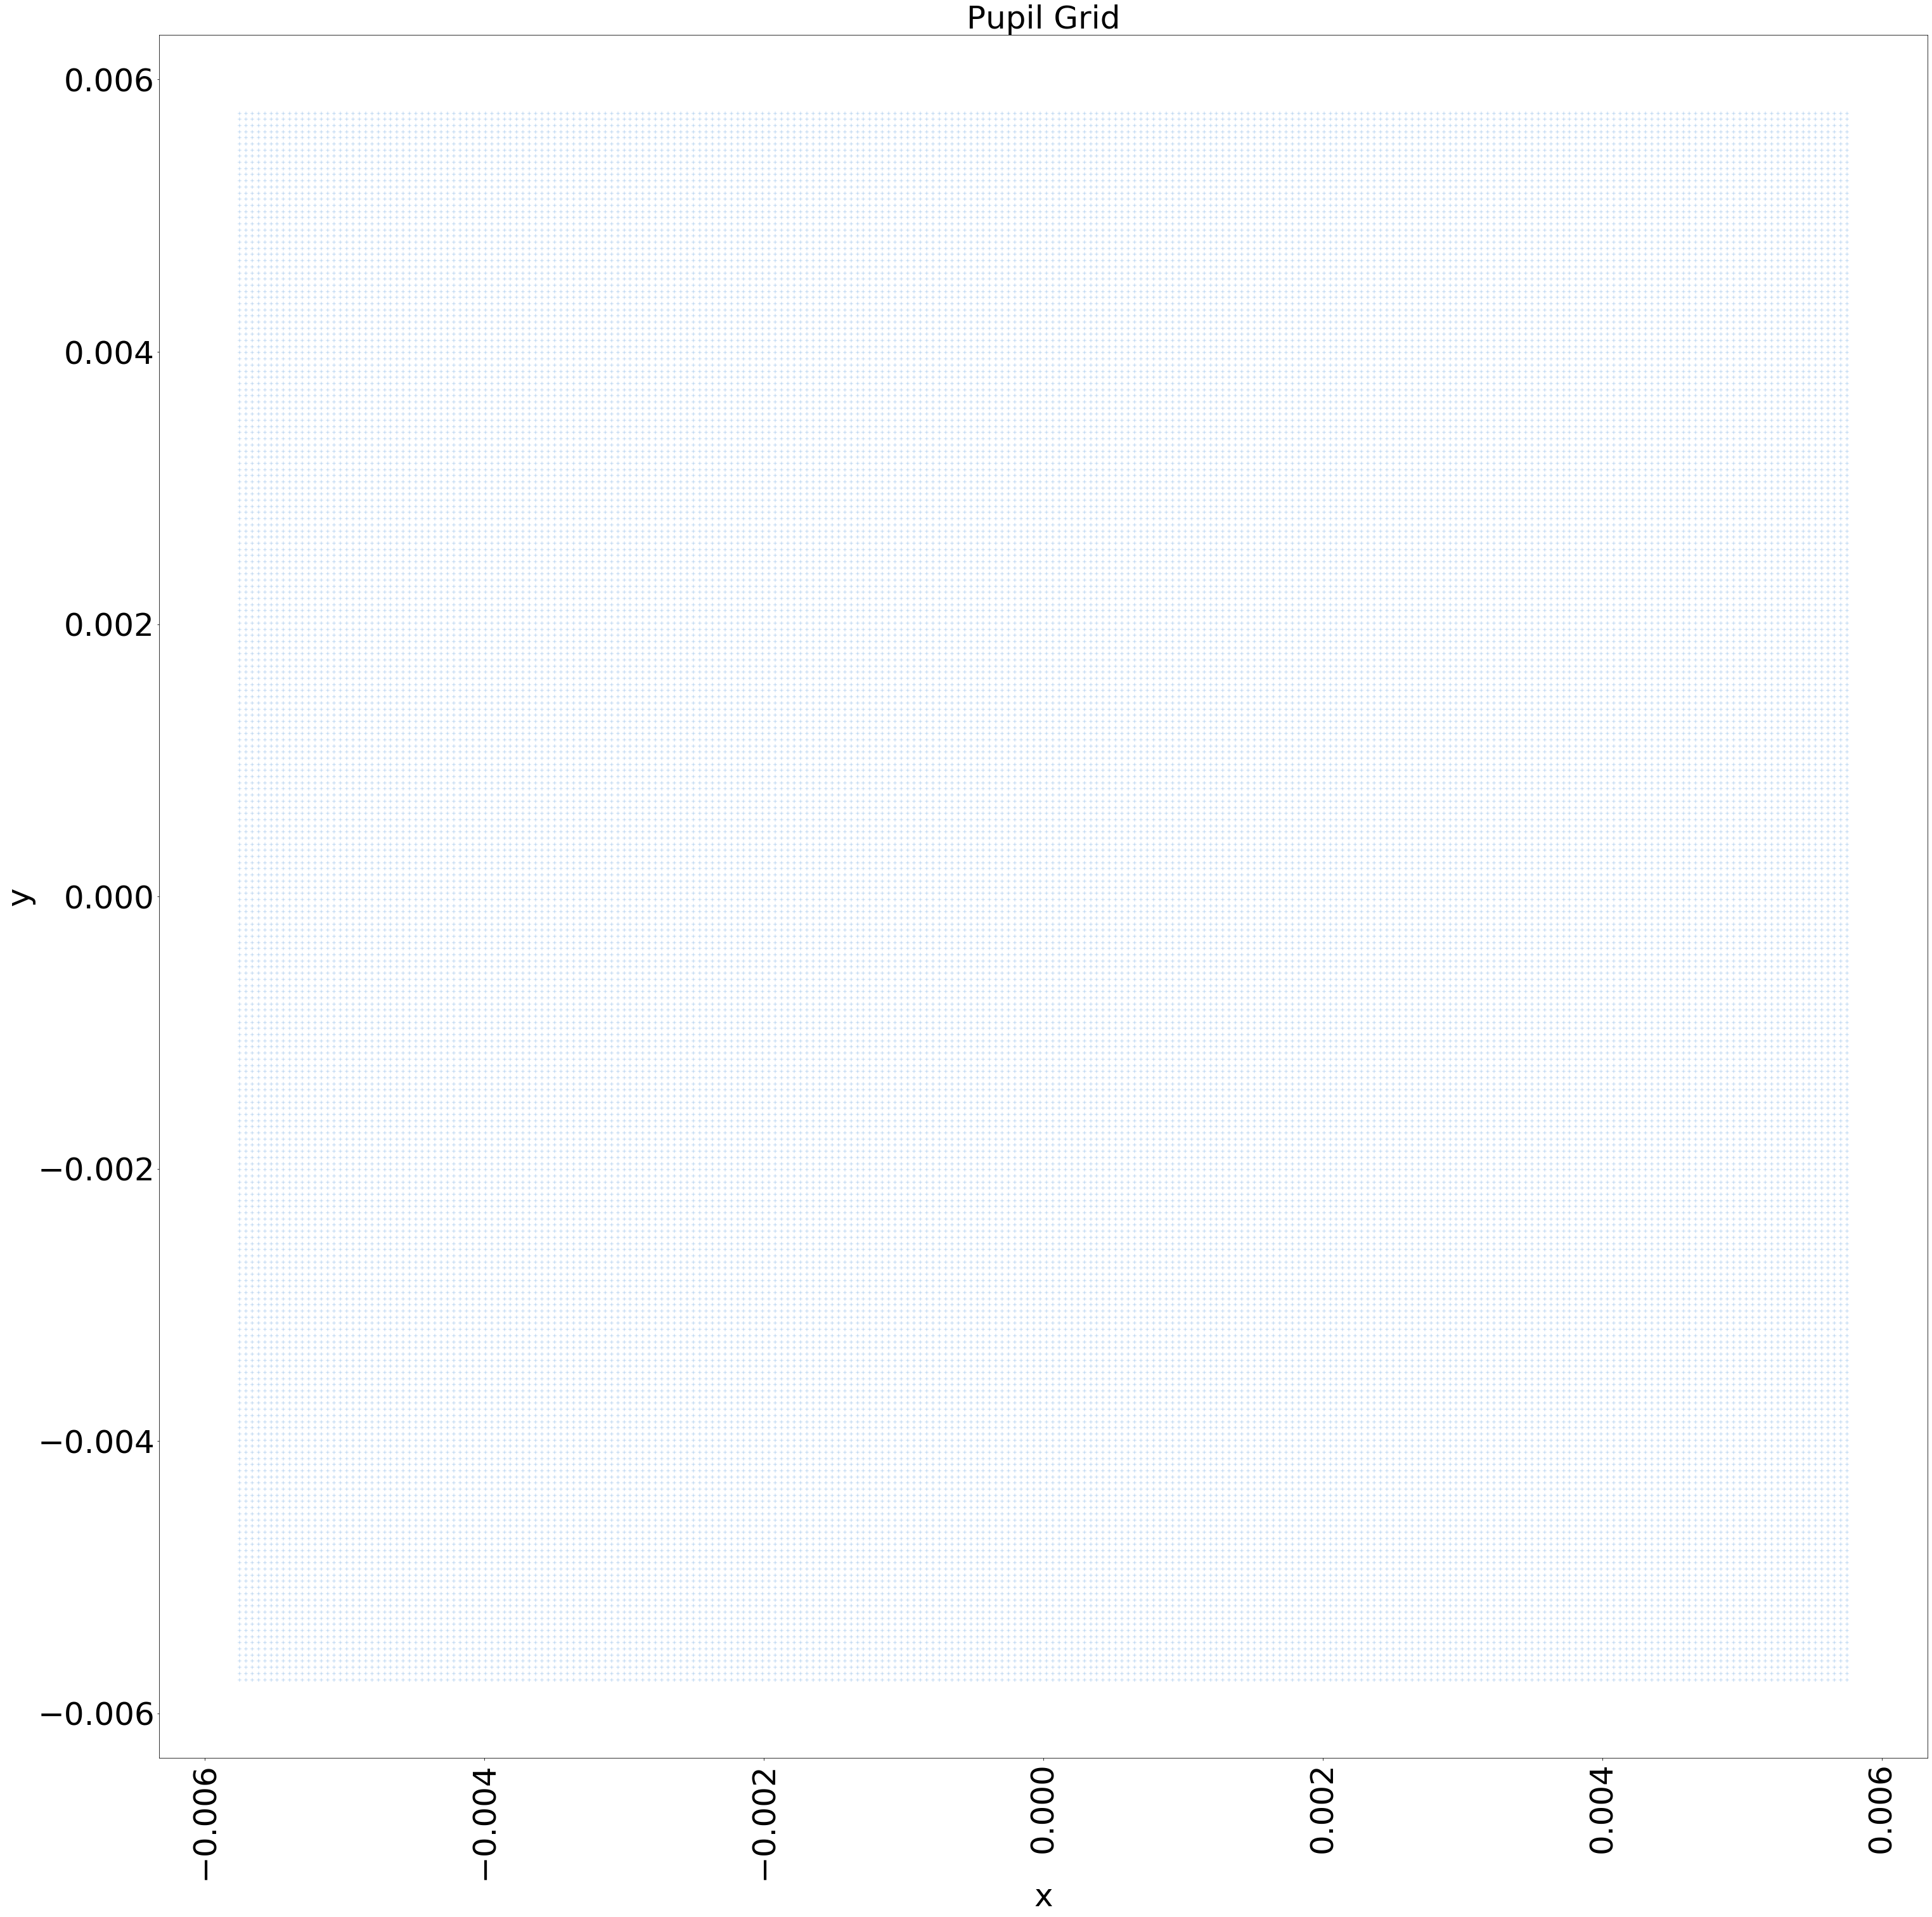

In [7]:
# Create a demagnifier
D = 10.5e-3
pupil_grid = make_pupil_grid(N, D*1.1)

## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.title('Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

mag = Magnifier(D/telescope_diameter) # take the pupil down from `telescope_diameter` to 10.5mm


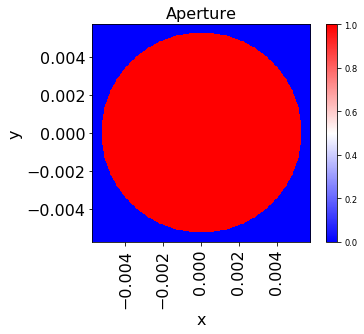

In [8]:
aperture = circular_aperture(D)

aperture_grid = aperture(pupil_grid)
imshow_field(aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [41]:
wf_ref = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_ref.total_power = 100000 # Photons per second
wf_ref_demag = mag.forward(wf_ref)


65536

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


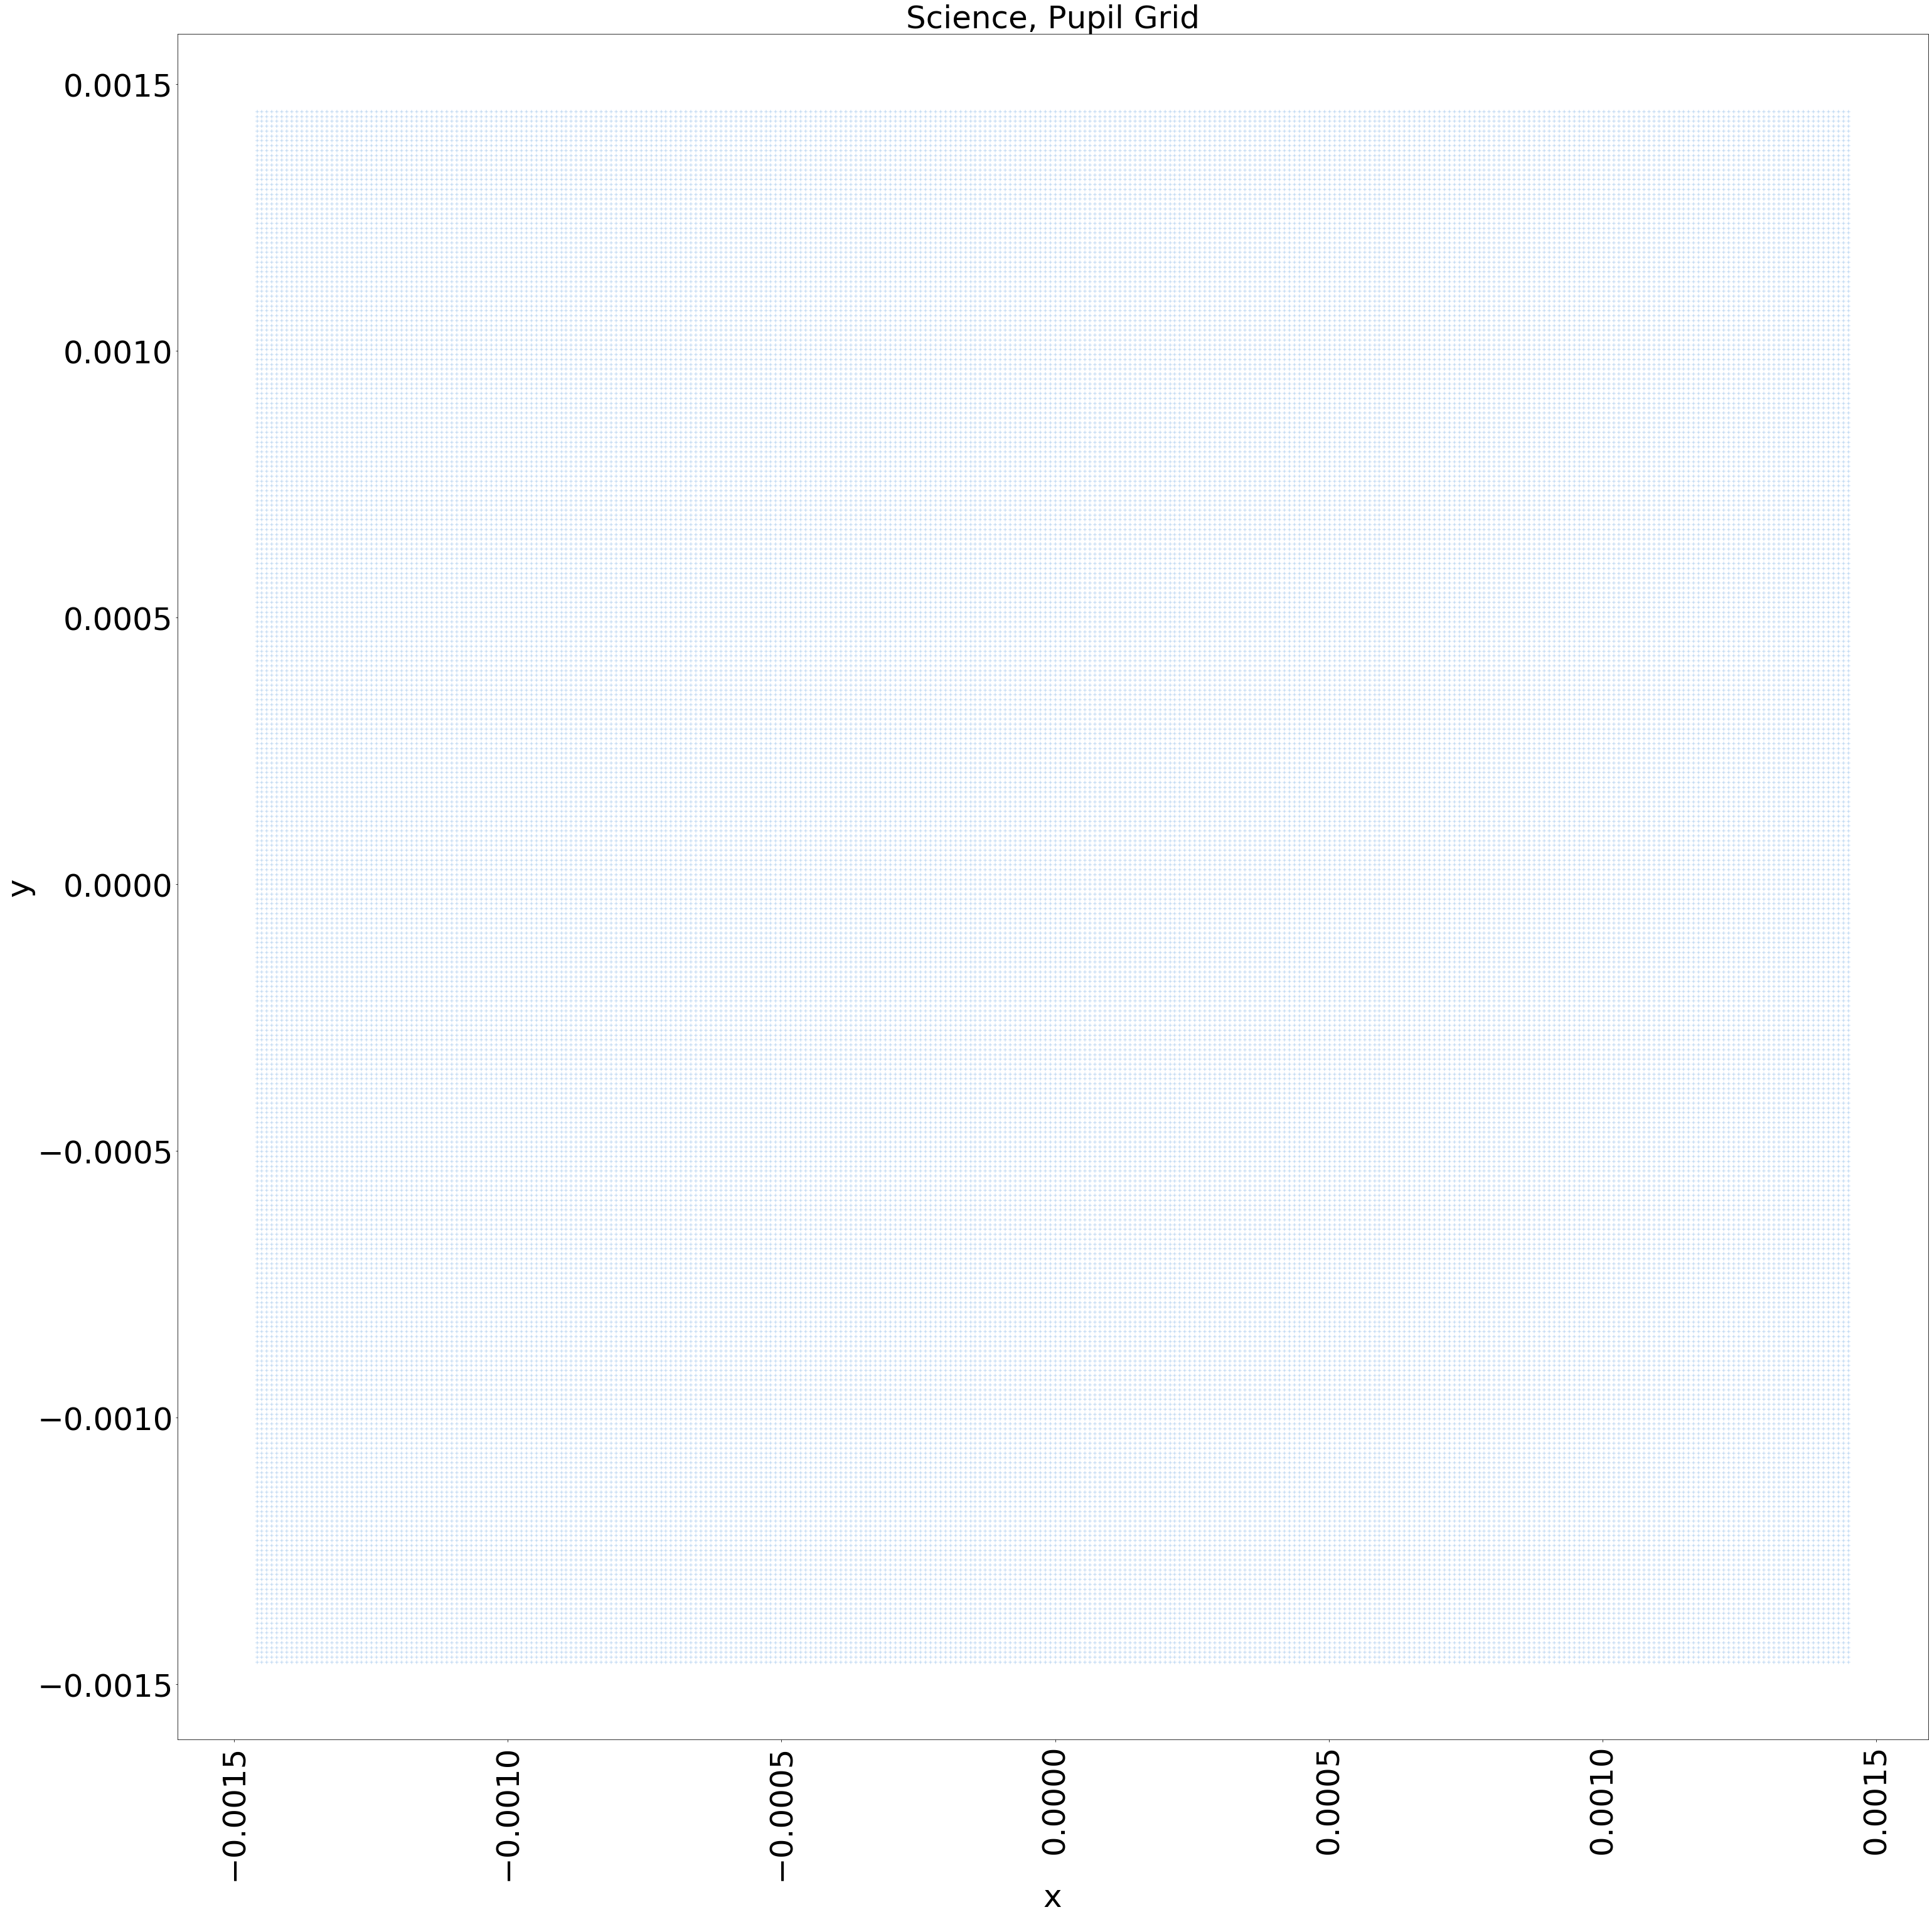

In [10]:
spatial_resolution = wavelength_wfs/telescope_diameter
#focal_grid = make_focal_grid(q = 8, num_airy = 20, spatial_resolution=spatial_resolution)
science_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength_wfs)

## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(science_focal_grid.x, science_focal_grid.y, '+')
plt.title('Science, Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

propagator = FraunhoferPropagator(pupil_grid, science_focal_grid)

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  """Entry point for launching an IPython kernel.


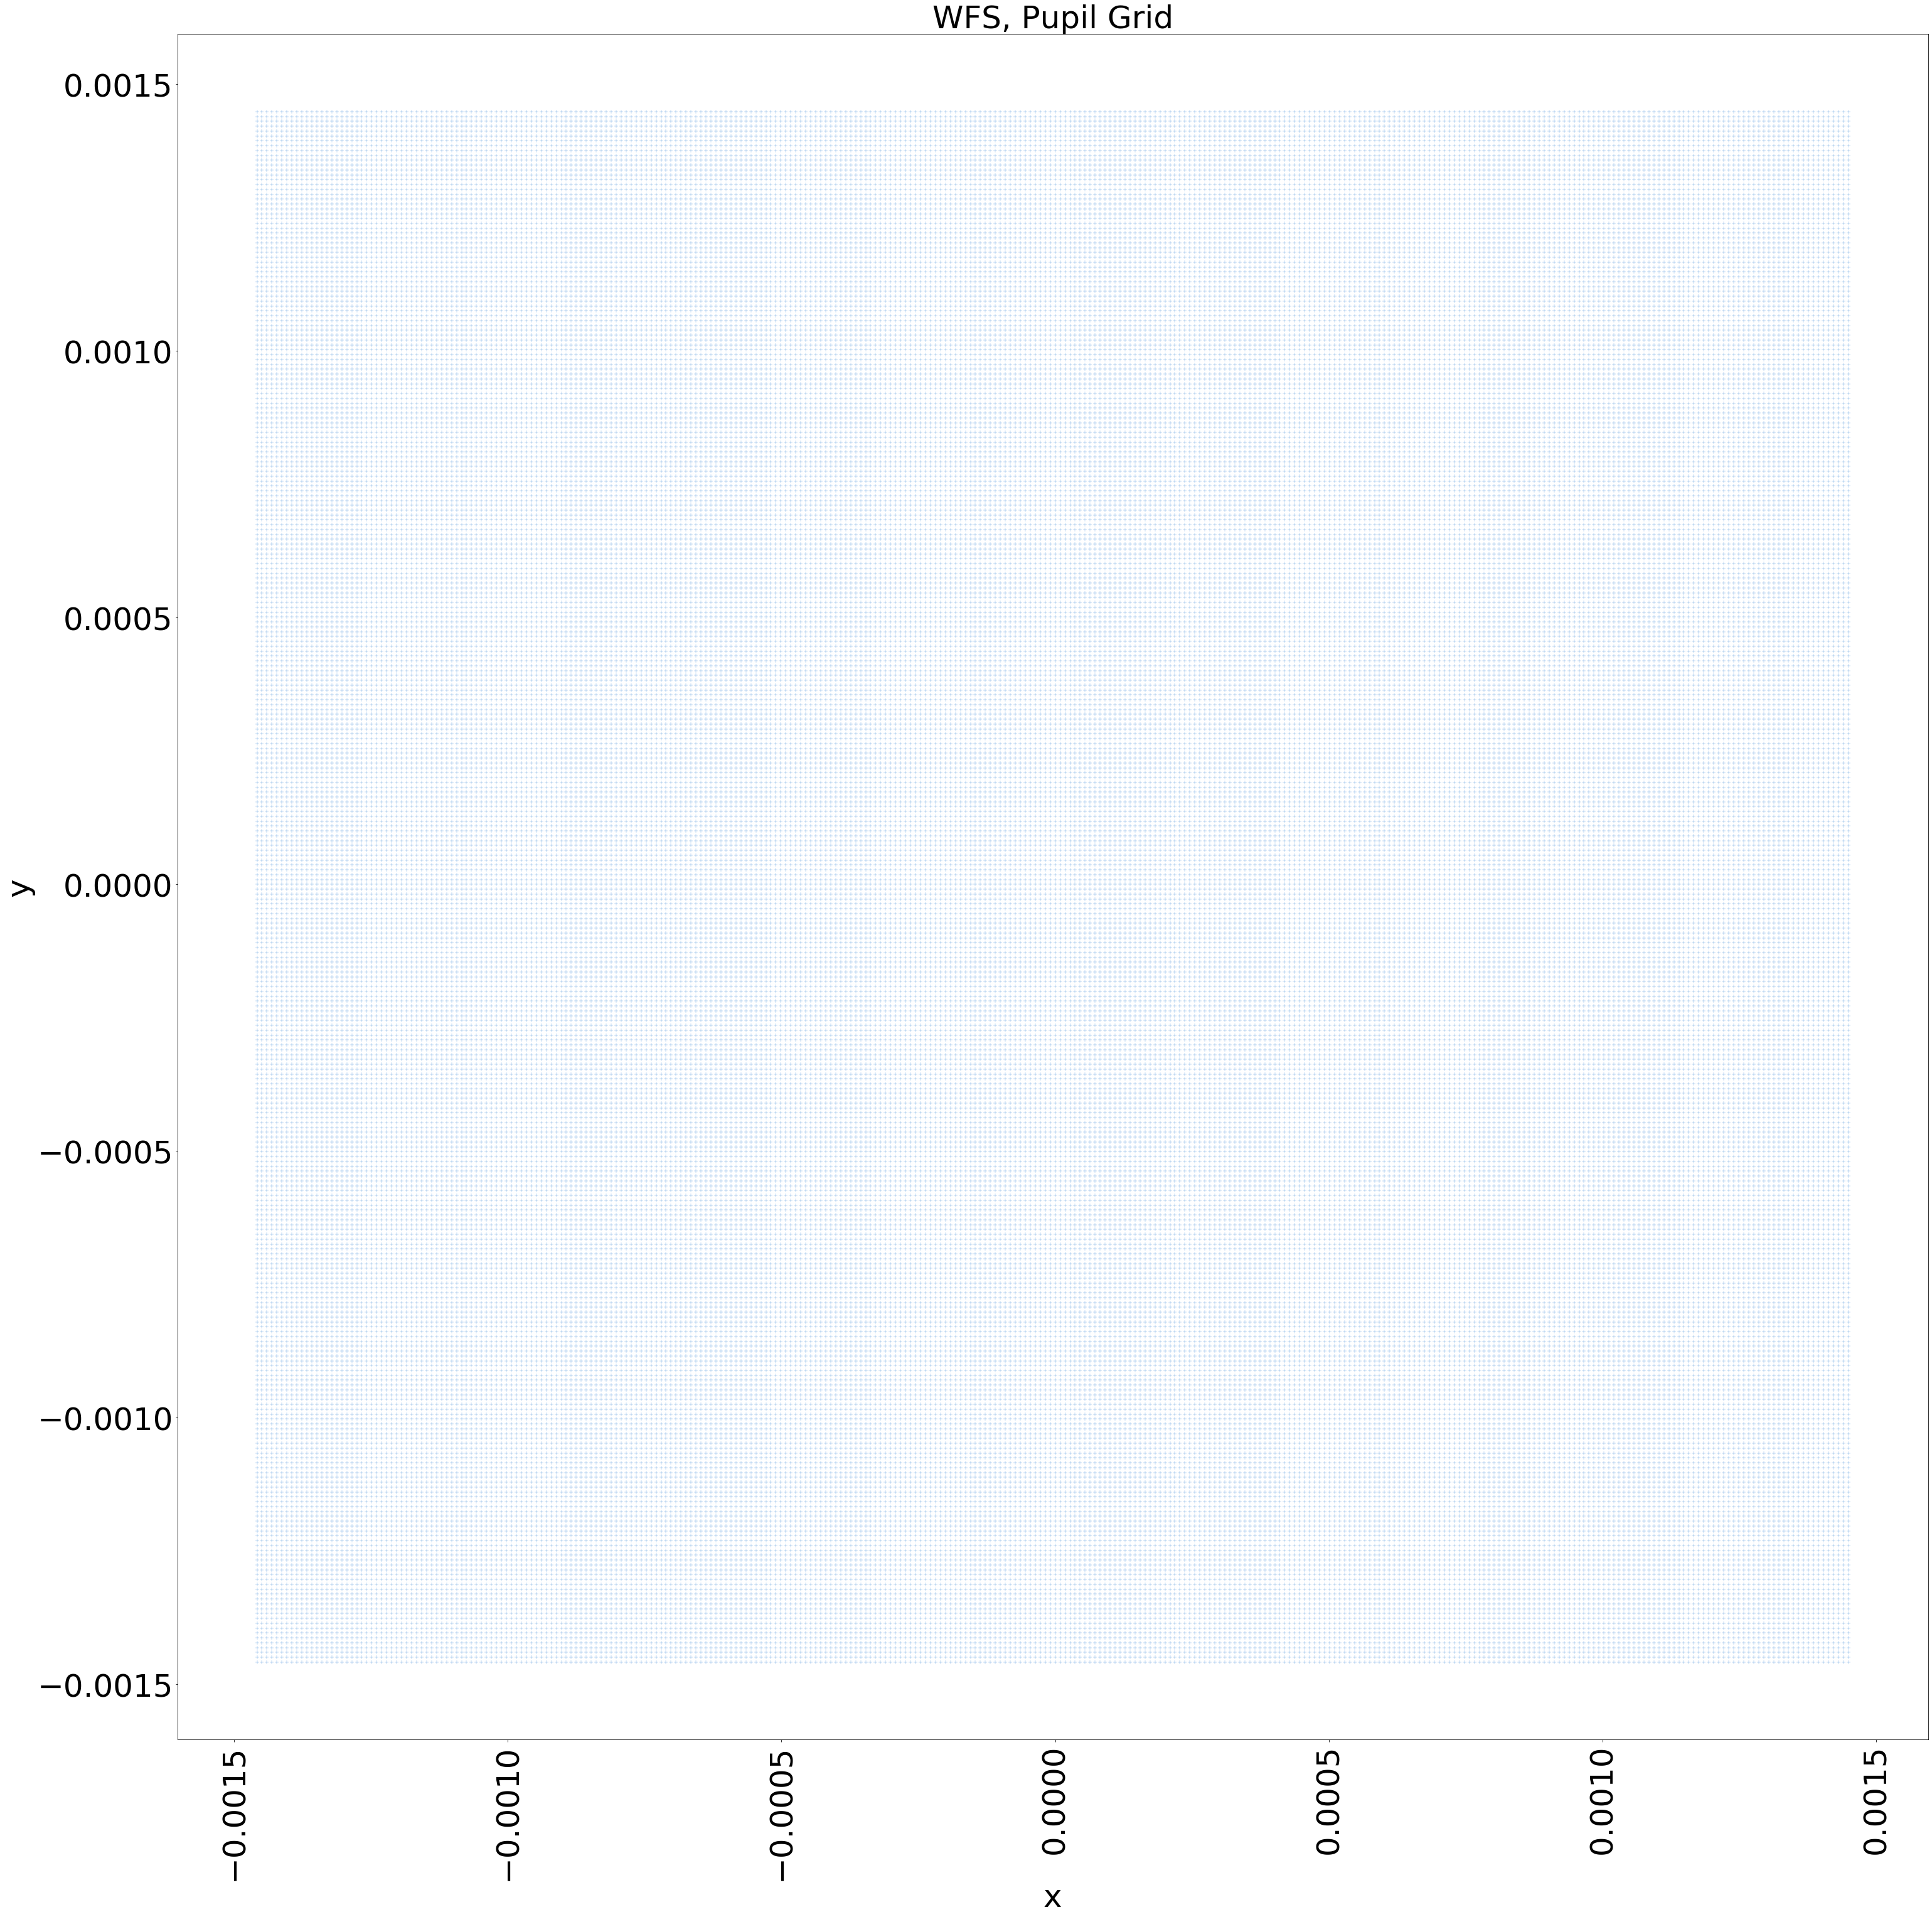

In [11]:
wfs_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength_wfs)

## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(wfs_focal_grid.x, wfs_focal_grid.y, '+')
plt.title('WFS, Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

In [12]:
# Create a detector 
science_camera = NoiselessDetector()


In [13]:
# Get the unit lambda/D which is useful for plotting focal plane images
l_D = wavelength_wfs/D
plot_grid = make_focal_grid( make_pupil_grid(N), 8, 20)


/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# Evolve the atmosphere
phasescreens = [] # keep track of atmospheric phase different timesteps
images = [] # Keep track of focal plane images at different timesteps

## Dynamic atmosphere simulation parameters
timesteps  = [1, 100, 1000]

wfatms_tel_list = []
wfatms_list = []
## Evolve atmospjere to these timesteps
for timestep in timesteps:
    # Update the phase screen
    atmosphere.evolve_until(timestep)
    wfatms_tel = atmosphere.forward(wf_ref) #Phase screen at telescope aperture
    wfatms_tel_list.append(wfatms_tel)
    
    wfatms = mag.forward(wfatms_tel)
    wfatms_list.append(wfatms)
    
    science_image = propagator(wfatms).power # Focal plane image
    
    phasescreens.append(wfatms.phase)
    
    images.append(science_image)

Text(0.5, 1.0, 'Time = 1000')

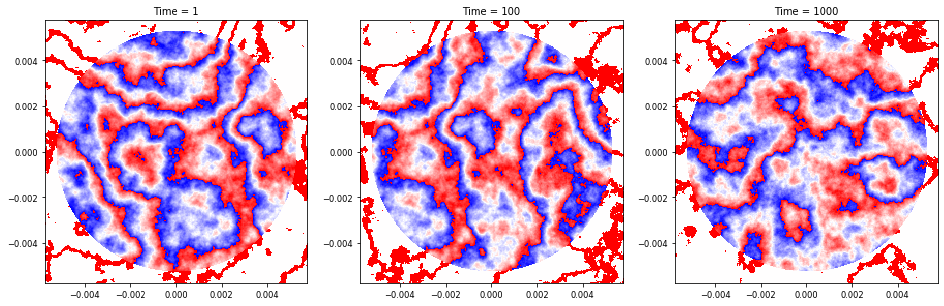

In [15]:
plt.figure(figsize=(16,16))

plt.subplot(1, 3, 1)
imshow_field(phasescreens[0], vmin = -np.pi, vmax = np.pi, cmap='bwr')
plt.title("Time = 1")
plt.subplot(1, 3, 2)
imshow_field(phasescreens[1], vmin = -np.pi, vmax = np.pi, cmap='bwr')
plt.title("Time = 100")
plt.subplot(1, 3, 3)
imshow_field(phasescreens[2], vmin = -np.pi, vmax = np.pi, cmap='bwr')
plt.title("Time = 1000")


Text(0.5, 1.0, 'Time = 1000')

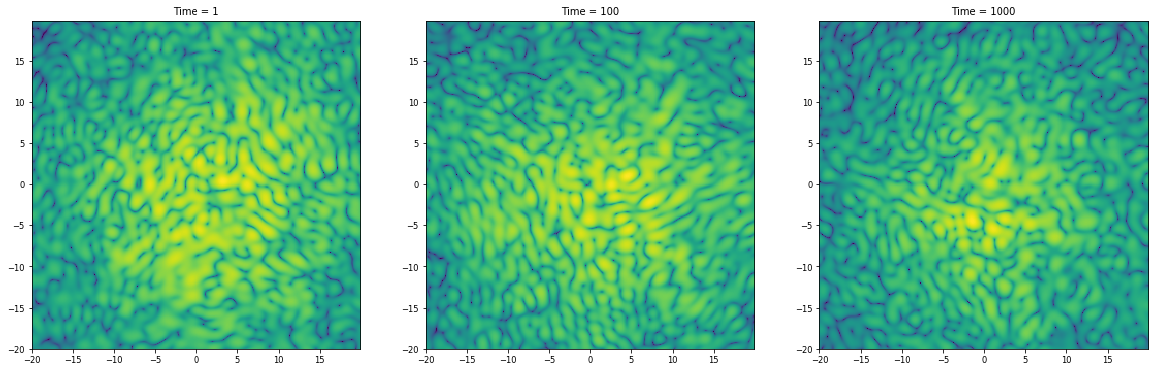

In [16]:
#  Plot the focal plane image at different timesteps
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
imshow_field(np.log10(images[0]/images[0].max()), vmin = -6, grid = plot_grid)
plt.title("Time = 1")
plt.subplot(1, 3, 2)
imshow_field(np.log10(images[1]/images[1].max()), vmin = -6, grid = plot_grid)
plt.title("Time = 100")
plt.subplot(1, 3, 3)
imshow_field(np.log10(images[2]/images[2].max()), vmin = -6, grid = plot_grid)
plt.title("Time = 1000")

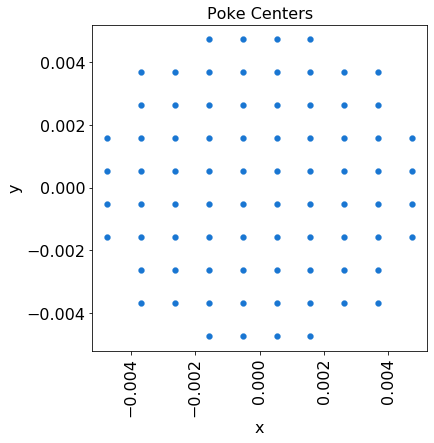

In [17]:
# Make deformable Mirror # At pupil plane (not telescope pupil plane)
num_actuators = 10
pitch = D / num_actuators # Sigma Square
poke_centers = make_pupil_grid(num_actuators, D) #aka actuator grids

poke_centers = poke_centers.subset(poke_centers.as_('polar').r < D / 2)

## Just plotting something
plt.figure(figsize=(6,6))
plt.plot(poke_centers.x, poke_centers.y, 'o')
plt.title('Poke Centers',fontsize=16)
xfont = plt.xlabel('x', fontsize=16)
yfont = plt.ylabel('y', fontsize=16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

Num of modes = 80


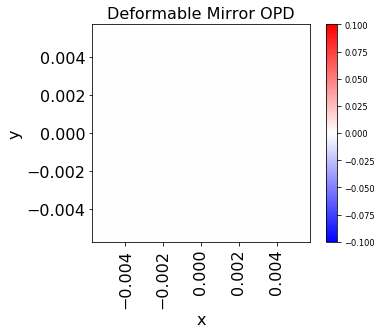

In [35]:
# This is my modes in Gaussian Basis
dm_modes = make_gaussian_pokes(pupil_grid, poke_centers,
                              pitch*np.sqrt(2))
num_modes = poke_centers.x.size
print('Num of modes = {:g}'.format(num_modes))
deformable_mirror = DeformableMirror(dm_modes)
deformable_mirror.actuators = np.zeros(num_modes)

imshow_field(deformable_mirror.opd, cmap = 'bwr')
plt.colorbar()
plt.title('Deformable Mirror OPD', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [19]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, wavelength_0=wavelength_wfs)
science_camera = NoiselessDetector()


In [ ]:


wf_ref_pwfs_fws = pwfs.forward(wf_ref_demag) 
science_camera.integrate(wf_ref_pwfs_fws,1)
image_ref = science_camera.read_out()

# Final reference image is divided by the total sume
# to normalize the wavefron sensor response. Doing this
# consequently for all exposures will make sure that we
# can use this reference for arbitrary exposure times
# and photon flux
image_ref /= image_ref.sum()
imshow_field(image_ref, cmap = 'bwr')
plt.colorbar()
plt.title('Reference Wavefront on Science Camera\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [21]:
# Create the interaction matrix
probe_amp = 0.01*wavelength_wfs
slopes = []

for ind in range(num_modes):
    if (ind+1)%10 == 0:
        print("Mesasure response to mode {:d}/{:d}\n".format(ind+1, num_modes))
    slope = 0
    
    # Probe the phase response
    for s  in [-1, 1]:
        amp = np.zeros((num_modes, ))
        amp[ind] = s * probe_amp
        
        deformable_mirror.actuators = amp
        
        dm_wf = deformable_mirror.forward(wf_ref_demag)
        wfs_wf = pwfs.forward(dm_wf)
        
        science_camera.integrate(wfs_wf, 1)
        image = science_camera.read_out()
        image /= np.sum(image)
        
        slope += s*(image - image_ref)/(2*probe_amp)
        
    slopes.append(slope)
    
slopes = ModeBasis(slopes)

input_opd = deformable_mirror.opd
print(input_opd)
print(len(input_opd))


input_opd = aperture_grid*(input_opd - np.mean(input_opd[aperture_grid>0]))
imshow_field(input_opd, cmap = 'bwr')
plt.colorbar()
plt.title('OPD on deformable Mirror\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()


Mesasure response to mode 10/80

Mesasure response to mode 20/80

Mesasure response to mode 30/80

Mesasure response to mode 40/80

Mesasure response to mode 50/80

Mesasure response to mode 60/80

Mesasure response to mode 70/80

Mesasure response to mode 80/80



In [23]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix,
                                        rcond=rcond, svd = None)


In [24]:
### Initialize the wavefront

In [25]:
wf_wfs = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_wfs.total_power = zero_magnitude_flux*10**(-stellar_magnitude/2.5)

wf_wfs_demag = mag.forward(wf_wfs)
print("Total photon flux {:g}".format(wf_wfs_demag.total_power))



Total photon flux 3.9e+10


In [26]:
AO_Frequency = 1000
delta_t = 1.0 /AO_Frequency
leakage = 0.01
gain = 0.5


In [39]:
wf_prop = propagator.forward(wf_wfs_demag) # Diffraction Limited Image
Inorm = wf_prop.power.max()
PSF_ideal = propagator.forward(deformable_mirror.forward(wf_wfs_demag)).power/Inorm

ideal_strehl = PSF_ideal.max()
print("Input Strehl for perfect image is: {:g}".format(ideal_strehl))

Input Strehl for perfect image is: 1


In [40]:

wf_abberated = wfatms_list[0]

wf_abberated_prop = propagator.forward(wf_abberated)
Inorm = wf_abberated_prop.power.max()
PSF_aberrated = propagator.forward(deformable_mirror.forward(wf_abberated)).power/Inorm

aberrated_strehl = PSF_aberrated.max()
print("Input Strehl (i.e. aberrated) image is: {:g}".format(aberrated_strehl))

Input Strehl (i.e. aberrated) image is: 1


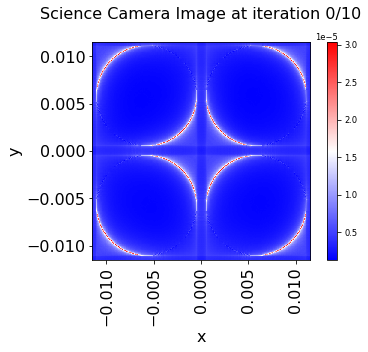

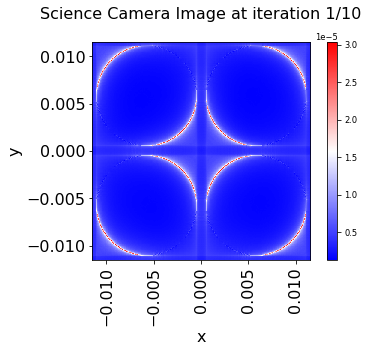

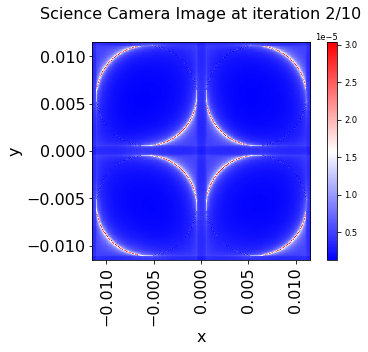

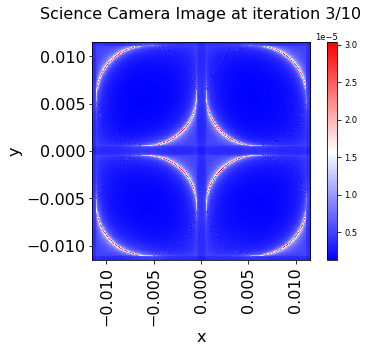

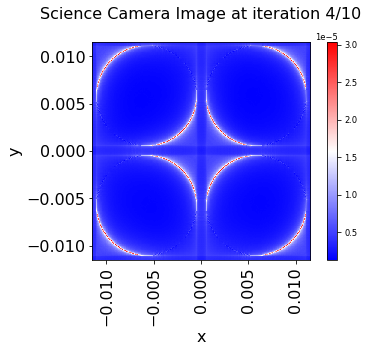

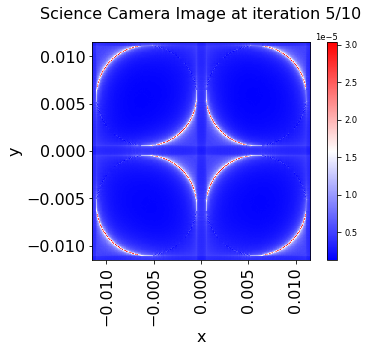

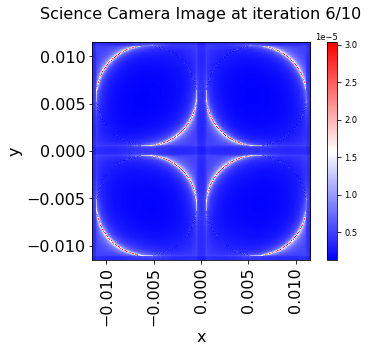

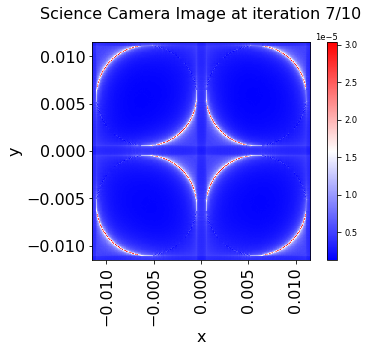

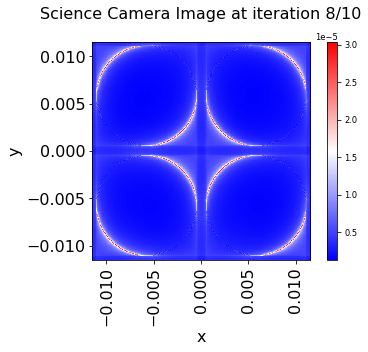

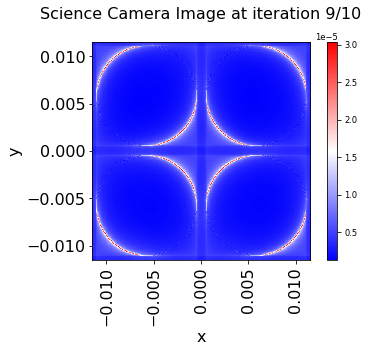

In [30]:



## Run the system in closed loop.
for i in range(10):
    wf_dm = deformable_mirror(wf_abberated)
    wf_pyramid = pwfs.forward(wf_dm)
    science_camera.integrate(wf_pyramid, 1)
    
    
    wfs_image = large_poisson( science_camera.read_out() ).astype(np.float)
    wfs_image /= np.sum(wfs_image)
    
    imshow_field(image, cmap = 'bwr')
    plt.colorbar()
    plt.title('Science Camera Image at iteration {}/{}\n'.format(i, 10), fontsize=16)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    xticks = plt.xticks(fontsize=16, rotation=90)
    yticks = plt.yticks(fontsize=16, rotation=0)
    plt.show()
    
    diff_image = wfs_image - image_ref
    deformable_mirror.actuators = (1 - leakage)*deformable_mirror.actuators - gain*reconstruction_matrix.dot(diff_image)
    
PSF_out = propagator.forward(deformable_mirror.forward(wf_wfs_demag)).power/Inorm

In [31]:
PSF_out

Field([1.87713917e-06, 1.41912289e-06, 1.06408162e-06, ...,
       3.03148226e-06, 2.00800472e-06, 1.00016177e-06])

In [32]:
## Comparison

residual_opd = deformable_mirror.opd
residual_opd = aperture_grid*(residual_opd - np.mean(residual_opd[aperture_grid>0]))

phase_rms = 2*np.pi/wavelength_wfs*np.std(residual_opd[aperture_grid>0])
strehl = PSF_out.max()

print("Estimated Strehl Input {:g} and Output {:g}".format(
input_strel, strehl))

Estimated Strehl Input 0.999399 and Output 0.0546706


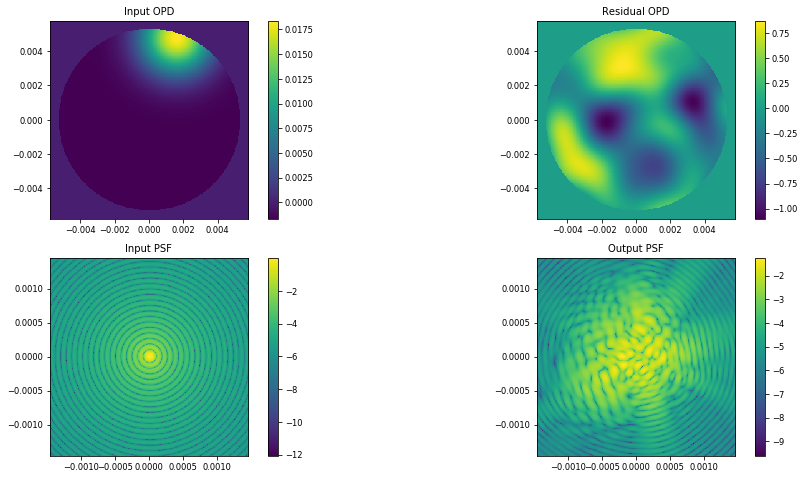

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
imshow_field(input_opd/wavelength_wfs)
plt.title('Input OPD')
plt.colorbar()

plt.subplot(2,2,2)
imshow_field(residual_opd/wavelength_wfs)
plt.title('Residual OPD')
plt.colorbar()

plt.subplot(2,2,3)
imshow_field(np.log10(PSF_in))
plt.title('Input PSF')
plt.colorbar()

plt.subplot(2,2,4)
imshow_field(np.log10(PSF_out))
plt.title('Output PSF')
plt.colorbar()
